<div align = "center">

# **Primas Stop-Loss**

</div>

## Data

In [207]:
severidad_individual <- read.csv("../data/processed/severidad_completa.csv")$x
cdf_agregada <- read.csv("../data/output/perdida_agregada_total_portafolio.csv")$cdf
pmf_agregada <- read.csv("../data/output/perdida_agregada_total_portafolio.csv")$pmf

## Ajuste de la severidad individual

In [208]:
source("../src/utils/Excluir_outliers.R")
source("../src/utils/Estimadores_severidad.R")

### Limpieza de outliers en severidad individual

In [209]:
resultado_limpieza <- Excluir_outliers(severidad_individual, 
                                       threshold = 3.5, 
                                       percentil_corte = 2.0, 
                                       silencioso = FALSE)

severidad_limpia <- resultado_limpieza$datos_limpios

cat("Datos originales:", length(severidad_individual), "\n")
cat("Datos después de limpieza:", length(severidad_limpia), "\n")
cat("Outliers removidos:", resultado_limpieza$estadisticas$n_outliers, "\n")
cat("Porcentaje de outliers:", round(resultado_limpieza$estadisticas$porcentaje_outliers, 2), "%\n")

═══════════════════════════════════════════════════════════════════════════
                    DETECCIÓN DE OUTLIERS - MÉTODO COMBINADO                
═══════════════════════════════════════════════════════════════════════════
Datos originales: 19532 | Datos positivos: 19532
Método 1 - Percentiles: 2.0% cada extremo (268393.66 - 24458579.82)
Método 2 - Z-score robusto: Threshold 3.5 | Mediana: 2573896.95 | MAD: 2183564.8292
───────────────────────────────────────────────────────────────────────────
Outliers por percentiles: 782 (4.0%)
Outliers por Z-score: 1093 (5.8%)
Outliers totales: 1875 (9.6%)
Datos limpios: 17657 (90.4%)
───────────────────────────────────────────────────────────────────────────
ESTADÍSTICAS DE OUTLIERS:
Rango outliers: [1724.49, 611088620.27]
Media outliers: 19094967.67 | Mediana outliers: 13445592.32
Z-score máximo: 10.02 | Z-score mínimo: 3.50

ESTADÍSTICAS DE DATOS LIMPIOS:
Rango limpios: [268395.44, 10215859.93]
Media limpios: 3046729.02 | Mediana limpios: 

Datos después de limpieza: 17657 
Outliers removidos: 1875 
Porcentaje de outliers: 9.6 %


### Ajuste de distribuciones a la severidad limpia

In [210]:
resultado_ajuste <- Estimadores_severidad(severidad_limpia)

mejor_distribucion <- resultado_ajuste$mejor_distribucion_aic
parametros_mejor <- resultado_ajuste$ajustes[[mejor_distribucion]]$parametros

cat("\n=== RESUMEN DEL AJUSTE ===\n")
cat("Mejor distribución:", mejor_distribucion, "\n")
cat("Parámetros estimados:\n")
print(parametros_mejor)

═══════════════════════════════════════════════════════════════════════════
                           ESTIMADORES DE SEVERIDAD                         
═══════════════════════════════════════════════════════════════════════════
N = 17657 | Media = 3046729.02 | Mediana = 2398752.87 | CV = 0.7277
───────────────────────────────────────────────────────────────────────────

1. AJUSTE DE DISTRIBUCIONES:
───────────────────────────────────────────────────────────────────────────
Normal      : μ=3046729.02, σ=2216890.60 | AIC=566107.01 | BIC=566122.57
Gamma       : α=1.8742, β=0.0000 | AIC=559092.68 | BIC=559108.24
Weibull     : k=1.4279, λ=3354934.89 | AIC=559364.36 | BIC=559379.92
Lognormal   : μ=14.6397, σ=0.8103 | AIC=559670.58 | BIC=559686.14

2. PRUEBAS DE BONDAD DE AJUSTE (Kolmogorov-Smirnov):
───────────────────────────────────────────────────────────────────────────
Normal      : D=0.1160 | p-valor=0.0000 | Mal ajuste
Gamma       : D=0.0267 | p-valor=0.0000 | Mal ajuste
Weibull     

Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'Gamma(α=1.874, β=6e-07)' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'Gamma(α=1.874, β=6e-07)' in 'mbcsToSbcs': dot substituted for <b1>”
Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'Gamma(α=1.874, β=6e-07)' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'Gamma(α=1.874, β=6e-07)' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in text.default(x, y, ...):
“conversion failure on 'Gamma(α=1.874, β=6e-07)' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in text.default(x, y, ...):
“conversion failure on 'Gamma(α=1.874, β=6e-07)' in 'mbcsToSbcs': dot substituted for <b1>”


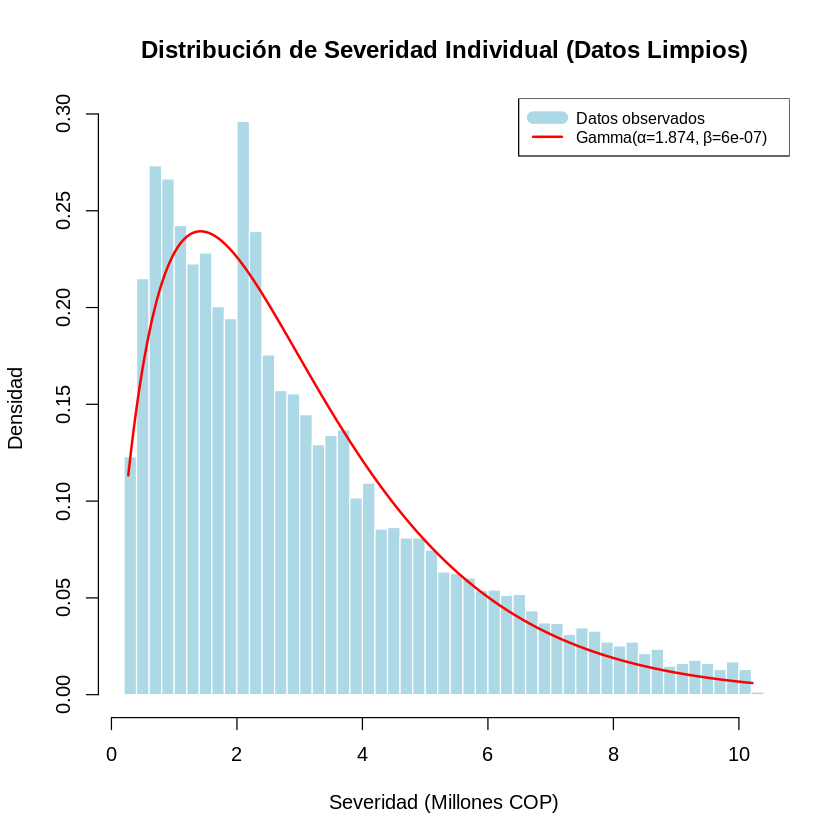

In [211]:
hist(severidad_limpia/1e6, 
     breaks = 50, 
     prob = TRUE,
     main = "Distribución de Severidad Individual (Datos Limpios)",
     xlab = "Severidad (Millones COP)",
     ylab = "Densidad",
     col = "lightblue",
     border = "white")

shape_param <- parametros_mejor$shape
rate_param <- parametros_mejor$rate

x_vals <- seq(min(severidad_limpia), max(severidad_limpia), length.out = 1000)
y_vals <- dgamma(x_vals, shape = shape_param, rate = rate_param)

lines(x_vals/1e6, y_vals*1e6, col = "red", lwd = 2)

legend("topright", 
       legend = c("Datos observados", 
                  paste0("Gamma(α=", round(shape_param, 3), ", β=", round(rate_param, 7), ")")),
       col = c("lightblue", "red"),
       lty = c(1, 1),
       lwd = c(10, 2),
       cex = 0.8)

In [212]:
png("../images/ajuste_gamma_severidad_individual.png", width = 800, height = 600, res = 100)
hist(severidad_limpia/1e6, 
     breaks = 50, 
     prob = TRUE,
     main = "Distribución de Severidad Individual (Datos Limpios)",
     xlab = "Severidad (Millones COP)",
     ylab = "Densidad",
     col = "lightblue",
     border = "white")

shape_param <- parametros_mejor$shape
rate_param <- parametros_mejor$rate

x_vals <- seq(min(severidad_limpia), max(severidad_limpia), length.out = 1000)
y_vals <- dgamma(x_vals, shape = shape_param, rate = rate_param)

lines(x_vals/1e6, y_vals*1e6, col = "red", lwd = 2)

legend("topright", 
       legend = c("Datos observados", 
                  paste0("Gamma(α=", round(shape_param, 3), ", β=", round(rate_param, 7), ")")),
       col = c("lightblue", "red"),
       lty = c(1, 1),
       lwd = c(10, 2),
       cex = 0.8)
dev.off()

pdf 
  2

## Cálculo de Prima Stop-Loss

Para una póliza stop-loss con deducible d, la prima se calcula como:
**Prima Stop-Loss = E[max(X - d, 0)]**

Donde X sigue una distribución Gamma con los parámetros estimados.

In [213]:
source("../src/utils/Prima_stop_loss.R")

parametros_gamma <- list(
  shape = parametros_mejor$shape,
  rate = parametros_mejor$rate
)

cat("Parámetros Gamma:\n")
cat("Shape (α):", parametros_gamma$shape, "\n")
cat("Rate (β):", parametros_gamma$rate, "\n")
cat("Media de la distribución:", parametros_gamma$shape/parametros_gamma$rate, "\n\n")

resultado_primas <- Prima_stop_loss_multiple("gamma", parametros_gamma, 
                                            desde = 50000, hasta = 10000000, paso = 50000)

cat("PRIMERAS 10 PRIMAS STOP-LOSS:\n")
cat("=============================\n")
print(head(resultado_primas, 10))

cat("\nÚLTIMAS 10 PRIMAS STOP-LOSS:\n")
cat("============================\n")
print(tail(resultado_primas, 10))

Parámetros Gamma:
Shape (α): 1.874214 
Rate (β): 6.151562e-07 
Media de la distribución: 3046728 

Calculando primas stop-loss para 200 niveles de deducible...
Rango: 50,000 a 1e+07 COP

PRIMERAS 10 PRIMAS STOP-LOSS:
   deducible deducible_millones prima_stop_loss prima_millones
1      50000               0.05         2994976       2.994976
2     100000               0.10         2945063       2.945063
3     150000               0.15         2895283       2.895283
4     200000               0.20         2845685       2.845685
5     250000               0.25         2796315       2.796315
6     300000               0.30         2747214       2.747214
7     350000               0.35         2698420       2.698420
8     400000               0.40         2649964       2.649964
9     450000               0.45         2601879       2.601879
10    500000               0.50         2554192       2.554192
   ratio_prima_deducible
1              59.899513
2              29.450632
3              

In [214]:
# Crear tabla simplificada con d y π_X(d)
tabla_primas <- data.frame(
  d = resultado_primas$deducible,
  pi_X_d = resultado_primas$prima_stop_loss
)

cat("TABLA DE PRIMAS STOP-LOSS:\n")
cat("==========================\n")
cat("Variable 'tabla_primas' creada con columnas:\n")
cat("- d: Deducible en COP\n") 
cat("- pi_X_d: Prima stop-loss π_X(d) en COP\n\n")

cat("Primeras 10 filas:\n")
print(head(tabla_primas, 10))

cat("\nÚltimas 10 filas:\n")
print(tail(tabla_primas, 10))

cat("\nDimensiones de la tabla:", nrow(tabla_primas), "filas x", ncol(tabla_primas), "columnas\n")

TABLA DE PRIMAS STOP-LOSS:
Variable 'tabla_primas' creada con columnas:
- d: Deducible en COP
- pi_X_d: Prima stop-loss π_X(d) en COP

Primeras 10 filas:
        d  pi_X_d
1   50000 2994976
2  100000 2945063
3  150000 2895283
4  200000 2845685
5  250000 2796315
6  300000 2747214
7  350000 2698420
8  400000 2649964
9  450000 2601879
10 500000 2554192

Últimas 10 filas:
           d   pi_X_d
191  9550000 29056.91
192  9600000 28273.33
193  9650000 27510.52
194  9700000 26767.93
195  9750000 26045.04
196  9800000 25341.34
197  9850000 24656.34
198  9900000 23989.54
199  9950000 23340.48
200 10000000 22708.69

Dimensiones de la tabla: 200 filas x 2 columnas


## Primas Stop Loss X

In [215]:
write.csv(tabla_primas, "../data/output/primas_sl_X.csv")

## Primas Stop Loss S

In [216]:
tabla_primas_S <- Prima_stop_loss_discreta_multiple(
  pmf = pmf_agregada,
  desde = 0,
  hasta = 300000000,  # Extendido hasta 300M para cubrir deducibles de 250M
  paso_deducibles = 1000000,  # Mantener paso de 1M para precisión
  paso_valores = 10000
)

cat("PRIMAS STOP-LOSS PÉRDIDA AGREGADA S:\n")
cat("===================================\n")
cat("Primeras 10 filas:\n")
print(head(tabla_primas_S, 10))

cat("\nÚltimas 10 filas:\n")
print(tail(tabla_primas_S, 10))

# Crear tabla simplificada para S
tabla_primas_S_simple <- data.frame(
  d = tabla_primas_S$d,
  pi_S_d = tabla_primas_S$pi_X_d
)

cat("\nTABLA SIMPLIFICADA PARA S:\n")
cat("==========================\n")
cat("Variable 'tabla_primas_S_simple' creada con columnas:\n")
cat("- d: Deducible en COP (múltiplos de 1,000,000)\n") 
cat("- pi_S_d: Prima stop-loss π_S(d) en COP\n\n")

cat("Dimensiones:", nrow(tabla_primas_S_simple), "filas x", ncol(tabla_primas_S_simple), "columnas\n")
cat("Rango de deducibles: desde", min(tabla_primas_S_simple$d)/1e6, "M hasta", max(tabla_primas_S_simple$d)/1e6, "M\n")

# Verificar algunos valores altos
cat("\nVerificación de valores altos de deducibles:\n")
valores_verificar <- c(50e6, 100e6, 150e6, 200e6, 250e6)
for(d_val in valores_verificar) {
  pi_val <- tabla_primas_S_simple$pi_S_d[tabla_primas_S_simple$d == d_val]
  if(length(pi_val) > 0) {
    cat("d =", d_val/1e6, "M -> π_S(d) =", pi_val, "COP\n")
  } else {
    cat("d =", d_val/1e6, "M -> NO ENCONTRADO\n")
  }
}

# Exportar tabla de S
write.csv(tabla_primas_S_simple, "../data/output/primas_sl_S.csv", row.names = FALSE)

Calculando primas stop-loss discretas para 301 niveles de deducible...
Rango deducibles: 0 a 3e+08 
Rango valores: 0 a 2e+09 
Paso valores: 10000 

PRIMAS STOP-LOSS PÉRDIDA AGREGADA S:
Primeras 10 filas:
       d   pi_X_d deducible_millones prima_millones ratio_prima_deducible
1  0e+00 12714886                  0      12.714886                   Inf
2  1e+06 11752979                  1      11.752979            11.7529786
3  2e+06 10818373                  2      10.818373             5.4091865
4  3e+06  9920234                  3       9.920234             3.3067446
5  4e+06  9064353                  4       9.064353             2.2660882
6  5e+06  8255142                  5       8.255142             1.6510284
7  6e+06  7495730                  6       7.495730             1.2492883
8  7e+06  6788025                  7       6.788025             0.9697178
9  8e+06  6132816                  8       6.132816             0.7666019
10 9e+06  5529898                  9       5.529898     

In [ ]:
png("../images/primas_stop_loss_S.png", width = 800, height = 600, res = 100)
plot(tabla_primas_S_simple$d/1e6, tabla_primas_S_simple$pi_S_d/1e6,
     type = "l",
     main = "Prima Stop-Loss para Pérdida Agregada S",
     xlab = "Deducible (Millones COP)",
     ylab = "Prima Stop-Loss (Millones COP)",
     col = "blue",
     lwd = 2)
grid()
dev.off()

## Tablas de probabilidad de solvencia

Vamos a realizar la siguiente tabla: $[F_S(\text{recaudo} + (1+\theta)\pi_S(d))]_{(\theta \in \{0.05, 0.1, 0.2\}, d \in 1000000\N)}$ pues $F_S(\text{recaudo} + (1+\theta)\pi_S(d)) = Pr(\text{Reclamos menores a los costos para retencion }d \text{ y sobrecosto } \theta \text{ a la prima stop-loss pura})$

In [217]:
# Definir parámetros
theta_values <- c(0.05, 0.1, 0.2)

# Incluir valores "ilógicos" de deducibles muy altos
d_values_normales <- seq(0, 50e6, by = 5e6)  # 0 a 50M en pasos de 5M
d_values_ilogicos <- c(100e6, 150e6, 200e6, 250e6)  # Valores ilógicamente altos
d_values <- c(d_values_normales, d_values_ilogicos)

# Usar el recaudo ya definido
recaudo <- 319732758

cat("Recaudo total:", recaudo, "COP\n")
cat("Deducibles normales (millones):", paste(d_values_normales/1e6, collapse = ", "), "\n")
cat("Deducibles ilógicos (millones):", paste(d_values_ilogicos/1e6, collapse = ", "), "\n")
cat("Total de columnas:", length(d_values), "\n\n")

# Inicializar la tabla de resultados
tabla_solvencia <- matrix(NA, nrow = length(theta_values), ncol = length(d_values))
rownames(tabla_solvencia) <- paste0("θ=", theta_values)
colnames(tabla_solvencia) <- paste0("d=", d_values/1e6, "M")

# Función para evaluar CDF considerando la discretización de 10,000
evaluar_cdf_discretizada <- function(valor, paso = 10000) {
  # Verificar que el valor esté en el rango válido
  if (valor < 0) return(0)
  
  # Calcular el índice correspondiente al valor discretizado
  # Los valores van de 0, 10000, 20000, ... hasta (length(cdf_agregada)-1)*10000
  indice <- floor(valor / paso) + 1
  
  # Verificar límites del vector
  if (indice > length(cdf_agregada)) {
    return(1)  # Si el valor está por encima del rango, probabilidad = 1
  }
  
  # Asegurar que el índice sea válido
  indice <- max(1, indice)
  
  # Para mejorar la precisión, hacer interpolación lineal entre puntos adyacentes
  if (indice < length(cdf_agregada)) {
    valor_inferior <- (indice - 1) * paso
    valor_superior <- indice * paso
    
    # Interpolación lineal
    peso <- (valor - valor_inferior) / paso
    cdf_interpolada <- cdf_agregada[indice] * (1 - peso) + cdf_agregada[indice + 1] * peso
    
    return(cdf_interpolada)
  } else {
    return(cdf_agregada[indice])
  }
}

# Mostrar información sobre la discretización
cat("INFORMACIÓN DE DISCRETIZACIÓN:\n")
cat("==============================\n")
cat("Paso de discretización:", 10000, "COP\n")
cat("Longitud del vector CDF:", length(cdf_agregada), "\n")
cat("Rango máximo cubierto:", (length(cdf_agregada)-1) * 10000, "COP (", ((length(cdf_agregada)-1) * 10000)/1e6, "M)\n\n")

# Calcular las probabilidades para cada combinación de θ y d
for (i in 1:length(theta_values)) {
  theta <- theta_values[i]
  
  for (j in 1:length(d_values)) {
    d <- d_values[j]
    
    # Encontrar π_S(d) en la tabla
    pi_S_d <- tabla_primas_S_simple$pi_S_d[tabla_primas_S_simple$d == d]
    
    # Verificar si encontramos el valor
    if(length(pi_S_d) == 0) {
      cat("WARNING: No se encontró π_S(d) para d =", d/1e6, "M\n")
      pi_S_d <- 0  # Usar 0 como valor por defecto
    }
    
    # Calcular el valor donde evaluar F_S
    valor_evaluacion <- recaudo - (1 + theta) * pi_S_d
    
    # Mostrar detalles del cálculo para verificación (solo algunos casos)
    if (i == 1 && (j <= 3 || j > length(d_values_normales))) {  # Primeros casos y casos ilógicos
      cat("θ =", theta, ", d =", d/1e6, "M:\n")
      cat("  π_S(d) =", pi_S_d, "COP\n")
      cat("  (1+θ)π_S(d) =", (1 + theta) * pi_S_d, "COP\n")
      cat("  Valor a evaluar =", valor_evaluacion, "COP (", valor_evaluacion/1e6, "M)\n")
    }
    
    # Calcular F_S(recaudo - (1+θ)π_S(d)) con discretización correcta
    prob_solvencia <- evaluar_cdf_discretizada(valor_evaluacion)
    
    # Guardar en la tabla
    tabla_solvencia[i, j] <- prob_solvencia
  }
}

# Mostrar la tabla
cat("\nTABLA DE PROBABILIDAD DE SOLVENCIA (COMPLETA)\n")
cat("=============================================\n")
cat("F_S(recaudo - (1+θ)π_S(d))\n\n")

print(round(tabla_solvencia, 4))

# Convertir a data frame para mejor visualización
df_solvencia <- as.data.frame(tabla_solvencia)

cat("\n\nTABLA EN FORMATO DATA FRAME:\n")
cat("============================\n")
print(df_solvencia)

Recaudo total: 319732758 COP
Deducibles normales (millones): 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50 
Deducibles ilógicos (millones): 100, 150, 200, 250 
Total de columnas: 15 

INFORMACIÓN DE DISCRETIZACIÓN:
Paso de discretización: 10000 COP
Longitud del vector CDF: 200001 
Rango máximo cubierto: 2e+09 COP ( 2000 M)

θ = 0.05 , d = 0 M:
  π_S(d) = 12714886 COP
  (1+θ)π_S(d) = 13350631 COP
  Valor a evaluar = 306382127 COP ( 306.3821 M)
θ = 0.05 , d = 5 M:
  π_S(d) = 8255142 COP
  (1+θ)π_S(d) = 8667899 COP
  Valor a evaluar = 311064859 COP ( 311.0649 M)
θ = 0.05 , d = 10 M:
  π_S(d) = 4978220 COP
  (1+θ)π_S(d) = 5227131 COP
  Valor a evaluar = 314505627 COP ( 314.5056 M)
θ = 0.05 , d = 100 M:
  π_S(d) = 11489.05 COP
  (1+θ)π_S(d) = 12063.5 COP
  Valor a evaluar = 319720695 COP ( 319.7207 M)
θ = 0.05 , d = 150 M:
  π_S(d) = 664.4986 COP
  (1+θ)π_S(d) = 697.7235 COP
  Valor a evaluar = 319732060 COP ( 319.7321 M)
θ = 0.05 , d = 200 M:
  π_S(d) = 38.26915 COP
  (1+θ)π_S(d) = 40.1826 COP


In [218]:
# Exportar tabla de solvencia
write.csv(df_solvencia, "../data/output/tabla_solvencia.csv", row.names = TRUE)